In [1]:
!pip install gym[atari]
!pip install gym[accept-rom-license]

In [2]:
from pickletools import uint8
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import progressbar
import cv2
import time


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
print(torch.__version__)

2.1.0+cu118


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
class cnn_model(nn.Module):

    def __init__(self, height, width, outputs):
        super(cnn_model, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(width,8,4),4,2),3,1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(height,8,4),4,2),3,1)
        self.fc4 = nn.Linear(convw*convh*64,256)
        self.fc5 = nn.Linear(256,128)
        self.head = nn.Linear(128,outputs)


    def forward(self, x):
        x = x.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        x = x.float()
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.fc4(x.view(x.size(0),-1)))
        x = F.relu(self.fc5(x))
        return self.head(x)

In [6]:
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
height, width, channels = env.observation_space.shape
nactions = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
batch_size = 128
gamma = 0.99
eps_start = 1
eps_end = 0.02
eps_decay = 200000
target_update = 1
lr = 1e-4
target_h = 80
target_w = 64
crop_dim = [20, height, 0, width]  # Cut 20 px from top to get rid of the score table

In [10]:
policy_net = cnn_model(target_w,target_h,nactions).to(device)
target_net = cnn_model(target_w,target_h,nactions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# policy_net = torch.load("./dqn/dqn_pong_model")
# target_net = torch.load("./dqn/dqn_pong_model")
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()

# setup optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayMemory(10000)
#memory = torch.load("./dqn/dqn_pong_model")

In [11]:
def preprocess(image):
    """
    Process image crop resize, grayscale and normalize the images
    """
    frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
    frame = frame[crop_dim[0]:crop_dim[1], crop_dim[2]:crop_dim[3]]  # Cut 20 px from top
    frame = cv2.resize(frame, (target_w, target_h))  # Resize
    frame = frame.reshape(target_w, target_h) / 255  # Normalize

    return frame

In [12]:
def select_action(state):
    global steps_done
    sample = random.random()
    #eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1. * steps_done / eps_decay)
    eps_threshold = max(0.02,eps_start - (eps_start - eps_end) * (steps_done / eps_decay))
    steps_done += 1
    if (sample > eps_threshold):
        with torch.no_grad():
            return policy_net(state.to(device)).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(nactions)]], device=device, dtype=torch.long)

In [13]:
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [14]:
def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)

    #This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    #next_state_batch = torch.cat(batch.next_state)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    #next_state_values = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [15]:
def display_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    """
    Displays a list of frames as a gif, with controls
    """
    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [16]:
def get_state(obs):
    state = preprocess(obs)
    #print(obs1.shape)
    #state = np.array(obs)
    state = np.stack((state, state, state, state))
    state = np.array(state)
    #print(state.shape)
    #state = state.transpose((2,0,1))
    #print(state.shape)
    state = torch.from_numpy(state)
    return state.unsqueeze(0)
    #return state

In [17]:
rewards_list = []
steps_done = 0
# steps_done = torch.load("./dqn/dqn_steps")
# rewards_list = torch.load("./dqn/dqn_rewards")

In [30]:
def train(env, num_episodes, device):
  initial_time = time.time()
  for i_episode in range(num_episodes):
      # Initialize the environment and state
      #env.reset()
      #last_screen = get_screen()
      #current_screen = get_screen()
      #state = current_screen - last_screen
      bar = progressbar.ProgressBar(1000, widgets=\
    [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
      bar.start()
      startTime = time.time()  # Keep time
      obs = env.reset()
      #print(obs)
      state = get_state(obs)

      total_reward = 0.0

      for t in count():
          # Select and perform an action
          action = select_action(state)
          obs, reward, done, _ = env.step(action.item())
          reward = torch.tensor([reward], device=device)
          total_reward += reward

          # Observe new state
          #last_screen = current_screen
          #current_screen = get_screen()
          if not done:
              #next_state = current_screen - last_screen
              next_state = get_state(obs)
          else:
              next_state = None

          # Store the transition in memory
          memory.push(state, action, next_state, reward)

          # Move to the next state
          state = next_state

          # Perform one step of the optimization (on the policy network)
          optimize_model()
          if t%10 == 0:
                bar.update(min(100,(t/10) + 1))
          if done:
              episode_durations.append(t + 1)
              plot_durations()
              break
      # Update the target network, copying all weights and biases in DQN
      if i_episode % target_update == 0:
          target_net.load_state_dict(policy_net.state_dict())
      bar.finish()
      currentTime = time.time()  # Keep current time
      time_passed = currentTime - startTime  # Find episode duration
      if i_episode % 1 == 0:
          rewards_list.append(total_reward.cpu().numpy())
      if i_episode % 1 == 0:
          print('Total steps: {} \t Episode: {}/{} \t Total reward: {} \t Time taken: {}'.format(steps_done, i_episode, num_episodes, total_reward, time_passed))
  env.close()

  torch.save(policy_net, "./dqn/dqn_pong_model")
  torch.save(steps_done, "./dqn/dqn_steps")
  torch.save(rewards_list, "./dqn/dqn_rewards")
  torch.save(memory, "./dqn/dqn_pong_memory")

  print('Complete')
  final_time = time.time()
#   total_time = torch.load("./dqn/dqn_time")
  total_time = 0
  total_time = total_time + final_time - initial_time
  torch.save(total_time, "./dqn/dqn_time")
  print('Total time taken {}'.format(total_time))
  plt.plot(np.squeeze(rewards_list))
  plt.ylabel('total rewards')
  plt.xlabel('episode number')
  plt.show()
  return

In [19]:
def test(env, num_episodes, results, device, render = True):
  policy_net = torch.load("./dqn/dqn_pong_model")
  for episode in range(num_episodes):
    obs,_ = env.reset()
    state = get_state(obs)
    total_reward = 0.0
    for t in count():
      action = policy_net(state.to(device)).max(1)[1].view(1,1)

      if render:
        env.render()
        time.sleep(0.02)

      obs, reward, done, info,_ = env.step(action)

      total_reward += reward

      if not done:
        next_state = get_state(obs)
      else:
        next_state = None

      state = next_state

      if done:
        #print("Finished Episode {} with reward {}".format(episode, total_reward))
        results.append(total_reward)
        break

    env.close()
  return results

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
device

device(type='cuda')

In [ ]:
# train model
train(env, 400, device)

<Figure size 640x480 with 0 Axes>

[=                                                                       ] N/A%
[=                                                                       ] N/A%

Total steps: 26350 	 Episode: 26/100 	 Total reward: tensor([-20.], device='cuda:0') 	 Time taken: 34.12493968009949


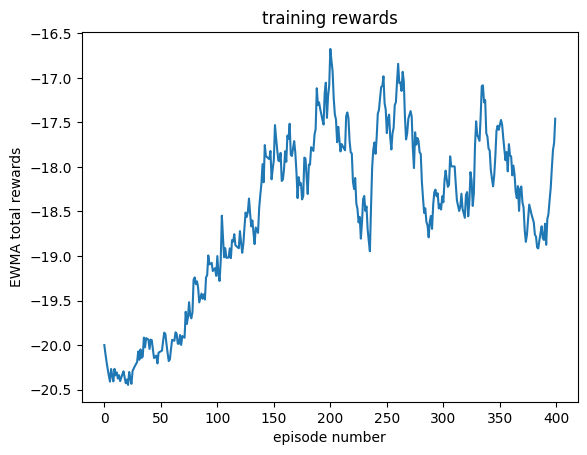

In [ ]:
rewards_lists = np.squeeze(rewards_list)
r = []
x = rewards_lists[0]
r.append(x)
for i in range(1,rewards_lists.size):
    x = 0.9*x+0.1*rewards_lists[i]
    r.append(x)
    #r.append(sum(rewards_lists[i:i+25]/(24+1)))
plt.plot(r)
plt.ylabel('EWMA total rewards')
plt.xlabel('episode number')
plt.title('training rewards')
plt.savefig('./dqn/DQN_EWMA.png', bbox_inches='tight')
plt.show()

In [ ]:
# test model
results = test(env, 400, [], device, render=False)

In [ ]:
print(steps_done)
total_time = torch.load("./dqn/dqn_time")
print(total_time)

552879
17840.47794699669


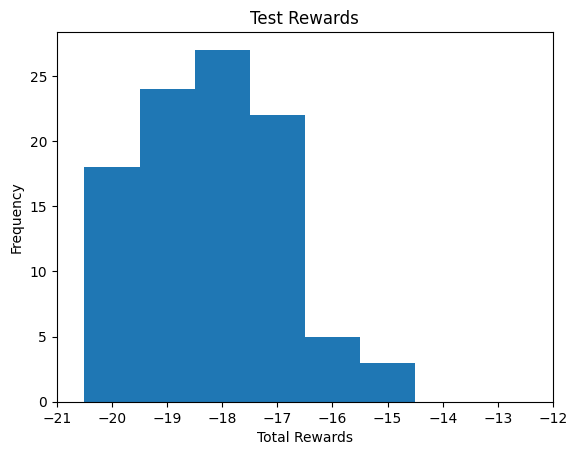

In [ ]:
data = np.squeeze(results)
plt.hist(data, bins=np.arange(data.min(), data.max()+1)-0.5)
plt.ylabel('Frequency')
plt.xlabel('Total Rewards')
plt.title('Test Rewards')
plt.xlim([-21, np.max(results)+1])
plt.savefig('./dqn/DQN_frequency.png', bbox_inches='tight')
plt.show()

In [ ]:
nr = np.array(results)
print(np.min(nr))
print(np.max(nr))
print(np.mean(nr))

-20.0
-13.0
-18.14


In [ ]:
rewards_list = torch.load("./dqn/dqn_rewards")

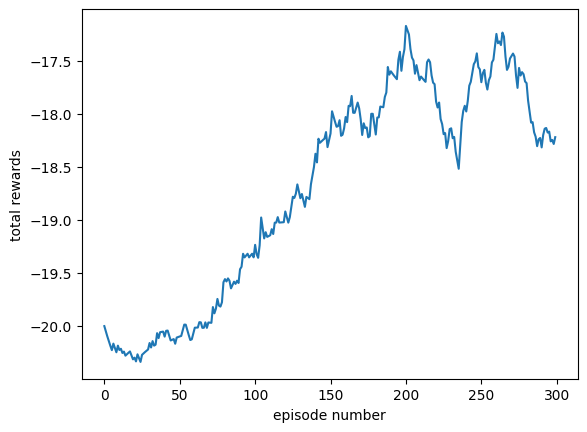

In [ ]:
rewards_lists = np.squeeze(rewards_list)
r = []
x = rewards_lists[0]
r.append(x)
for i in range(1,rewards_lists.size):
    x = 0.95*x+0.05*rewards_lists[i]
    r.append(x)
    #r.append(sum(rewards_lists[i:i+25]/(24+1)))
plt.plot(r)
plt.ylabel('total rewards')
plt.xlabel('episode number')
plt.show()

In [ ]:
resul = test(env, 1, [], device, render=True)

c:\Users\aadil\anaconda3\envs\gpu1\lib\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
